# Enrollment Prediction - Gradient Boosting & Propensity Scoring

### Goals

* Identify the effect of scholarship amounts on a student's decision to enroll at the UW or not
* Use the original approach of HCRC; a binary logistic regression. 

### Process

* A. Load in data and software libraries
* B. Set the option flags for this run
* C. Feature Engineering. Create derived metrics. 
* D. Normalize, clean up, and dummy-code various factors
* E. Split into training and test sets
* F. Run a gradient boosting classification
* G. Evaluate the results for accuracy
* H. Propensity Score Modeling

### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load in data and software libraries

**Load in the software libraries**

In [1]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, make_union

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split


#from tpot import TPOTClassifier

## Get propensity score libraries
from causalinference import CausalModel

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

/Users/devnambi/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/devnambi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Load in the data**

In [2]:
#df = pd.read_csv('Working_Data_set.csv')
#df = pd.read_csv('working_data_set_v2.csv.zip', compression='infer')
df = pd.read_csv('working_data_set_v3.csv')
retention_df = pd.read_csv('retention_info.csv')

In [3]:
df.loc[df.yr == 2010, 'Tuition'] = 25329
df.loc[df.yr == 2011, 'Tuition'] = 28058
df.loc[df.yr == 2012, 'Tuition'] = 29938
df.loc[df.yr == 2013, 'Tuition'] = 31971
df.loc[df.yr == 2014, 'Tuition'] = 33513
df.loc[df.yr == 2015, 'Tuition'] = 34143
df.loc[df.yr == 2016, 'Tuition'] = 34791

In [4]:
# Drop unneeded columns
df.drop('system_key', axis=1, inplace=True)
df.drop('GenderDesc', axis=1, inplace=True)
df.drop('EthnicityDesc', axis=1, inplace=True)
df.drop('HighSchoolCode', axis=1, inplace=True)

# Drop confounding columns
df.drop('EnrollYrQtr', axis=1, inplace=True)
df.drop('FirstYrGPA', axis=1, inplace=True)
df.drop('FirstYrCredits', axis=1, inplace=True)
df.drop('TestDesc', axis=1, inplace=True)
#df.drop('TotalBudgetRemaining', axis=1, inplace=True)
#df.drop('TuitionRemaining', axis=1, inplace=True)
#df.drop('Fisap_Income', axis=1, inplace=True)

# Dubious origin state
df.drop('OriginState', axis=1, inplace=True)

In [5]:
df_backup = df.copy(deep=True)

In [6]:
# Look at the columns in the data
df.columns

Index([u'yr', u'HighestParentalEducation', u'PurpleAndGoldAmount',
       u'IsEnrolledOrMatriculated', u'EFC', u'Fisap_Income',
       u'Grants_and_Scholarships', u'UW_Grants', u'WorkLoans', u'Tuition',
       u'TotalBudget', u'TuitionRemaining', u'TotalBudgetRemaining',
       u'HighSchoolGPA', u'TestScore', u'AcademicScore', u'AcademicRank',
       u'HolisticScore1', u'HolisticScore2', u'FinAidSegment',
       u'AcademicSegment', u'UWAttraction_TotalCount',
       u'UWAttraction_TotalPct', u'UWAttraction_ProdPct',
       u'UWLocationAttraction_TotalCount', u'UWLocationAttraction_TotalPct',
       u'UWEdGoals_TotalCount', u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct',
       u'LowerIncomePct', u'LowerIncomeCount', u'HigherIncomeCount',
       u'LowerParentEdPct', u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u

In [8]:
df.HolisticScore2.describe()

count    51489.000000
mean         1.461536
std          2.184097
min          0.000000
25%          0.000000
50%          0.000000
75%          4.333333
max          6.800000
Name: HolisticScore2, dtype: float64

## Part B - Set the option flags for this run

In [9]:
# Which years are around?
np.unique(df['yr'])

array([2014, 2015, 2016])

### Set All The Flags

1. Set the year
2. Set the number of interaction terms to use
3. Visualize or not
4. Normalize or not
5. Simple or detailed accuracy metrics

In [10]:
use_all_years = False
year = 2016

use_pugo_amounts = True

show_viz = False

normalize_metrics = False

detailed_accuracy_metrics = True

f_score_analysis = False

save_results = False

run_tpot = False

stratify_split = False

model_choice = 'boosting' # options are 'boosting' and 'logit'

#### Remove entries with missing data. 

In [11]:
if use_all_years == False:
    df = df.loc[df['yr'] == year]

df.drop('yr', axis=1, inplace=True)
df = df.reset_index(drop=True)

df = df[np.isfinite(df['EFC'])]

df.isnull().sum()

HighestParentalEducation           0
PurpleAndGoldAmount                0
IsEnrolledOrMatriculated           0
EFC                                0
Fisap_Income                       0
Grants_and_Scholarships            0
UW_Grants                          0
WorkLoans                          0
Tuition                            0
TotalBudget                        0
TuitionRemaining                   0
TotalBudgetRemaining               0
HighSchoolGPA                      0
TestScore                          0
AcademicScore                      0
AcademicRank                       0
HolisticScore1                     0
HolisticScore2                     0
FinAidSegment                      0
AcademicSegment                    0
UWAttraction_TotalCount            0
UWAttraction_TotalPct              0
UWAttraction_ProdPct               0
UWLocationAttraction_TotalCount    0
UWLocationAttraction_TotalPct      0
UWEdGoals_TotalCount               0
UWEdGoals_TotalPct                 0
U

## Part C - Derived Features

### Part C1 - Create derived features (feature engineering)

* need_after_grants = total budgets minus grants
* need_after_grantsandincome = total budgets minus grants minus efc
* the amount a student would spend after all grants / scholarships

In [12]:
#df['need_after_grants'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships']
#df['need_after_grants_efc'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']
if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PurpleAndGoldAmount'] - df['Grants_and_Scholarships']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['Grants_and_Scholarships']
#df['tuition_after_grants_efc'] = df['Tuition'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']

df.loc[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

df.drop('TotalBudget', axis=1, inplace=True)
df.drop('Tuition', axis=1, inplace=True)
df.drop('UW_Grants', axis=1, inplace=True)
df.drop('Grants_and_Scholarships', axis=1, inplace=True)
df.drop('AcademicRank', axis=1, inplace=True)
df.drop('PurpleAndGoldAmount', axis=1, inplace=True)

In [13]:
df.tuition_after_grants.describe()

count    18759.000000
mean     32060.972813
std       3328.246833
min      19476.000000
25%      28291.000000
50%      34791.000000
75%      34791.000000
max      34791.000000
Name: tuition_after_grants, dtype: float64

### Part C2 - Add retention info (feature engineering)

* 5-year graduation rate
* avg quarters to graduate
* avg+1 stdev quarters to graduate
* avg-1 stdev quarters to graduate

In [14]:
retention_df['5yr_grad_rate'] = retention_df['graduated_student_count'] * 1.0 / retention_df['student_count']

In [15]:
retention_df['avgplus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] + retention_df['stdev_quarters_to_graduate']
retention_df['avgminus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] - retention_df['stdev_quarters_to_graduate']
retention_df.ix[retention_df.avgminus1_quarters_to_graduate < 0, 'avgminus1_quarters_to_graduate'] = 0

/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


In [16]:
retention_df.drop('graduated_student_count', axis=1, inplace=True)
retention_df.drop('student_count', axis=1, inplace=True)
retention_df.drop('stdev_quarters_to_graduate', axis=1, inplace=True)

In [17]:
#retention_df[~retention_df.applymap(np.isreal).all(1)]

In [18]:
#retention_df.first_major_category.unique()

In [19]:
df['first_major_category'] = 'Unknown'
df.ix[df.BioAndMed == 1, 'first_major_category'] = 'BioAndMed'
df.ix[df.CompSci == 1, 'first_major_category'] = 'CompSci'
df.ix[df.Business == 1, 'first_major_category'] = 'Business'
df.ix[df.Eng == 1, 'first_major_category'] = 'Eng'
df.ix[df.PsychAnthro == 1, 'first_major_category'] = 'PsychAnthro'
df.ix[df.ArtDesign == 1, 'first_major_category'] = 'ArtDesign'
df.ix[df.Law == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.IntlStudies == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.Nursing == 1, 'first_major_category'] = 'Nursing'
df.ix[df.Com == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.Math == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.PhysicsAstr == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.Environ == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.English == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'

/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [20]:
df['LowerHighSchoolGPA'] = 0
df.ix[df.HighSchoolGPA > 3.0, 'LowerHighSchoolGPA'] = 3
df.ix[df.HighSchoolGPA > 3.4, 'LowerHighSchoolGPA'] = 3.4
df.ix[df.HighSchoolGPA > 3.6, 'LowerHighSchoolGPA'] = 3.6
df.ix[df.HighSchoolGPA > 3.8, 'LowerHighSchoolGPA'] = 3.8

In [21]:
df['UpperHighSchoolGPA'] = 3
df.ix[df.HighSchoolGPA > 3, 'UpperHighSchoolGPA'] = 3.4
df.ix[df.HighSchoolGPA > 3.4, 'UpperHighSchoolGPA'] = 3.6
df.ix[df.HighSchoolGPA > 3.6, 'UpperHighSchoolGPA'] = 3.8
df.ix[df.HighSchoolGPA > 3.8, 'UpperHighSchoolGPA'] = 4.0

In [22]:
#df.first_major_category.unique()

In [23]:
dfr = df.merge(retention_df, how='left', on=['first_major_category','LowerHighSchoolGPA','UpperHighSchoolGPA'])

In [24]:
dfr.drop('first_major_category', axis=1, inplace=True)
print('There are',dfr.HighSchoolGPA.count(),'rows')

('There are', 18759, 'rows')


In [25]:
list(dfr.columns)

['HighestParentalEducation',
 'IsEnrolledOrMatriculated',
 'EFC',
 'Fisap_Income',
 'WorkLoans',
 'TuitionRemaining',
 'TotalBudgetRemaining',
 'HighSchoolGPA',
 'TestScore',
 'AcademicScore',
 'HolisticScore1',
 'HolisticScore2',
 'FinAidSegment',
 'AcademicSegment',
 'UWAttraction_TotalCount',
 'UWAttraction_TotalPct',
 'UWAttraction_ProdPct',
 'UWLocationAttraction_TotalCount',
 'UWLocationAttraction_TotalPct',
 'UWEdGoals_TotalCount',
 'UWEdGoals_TotalPct',
 'UWEdGoals_ProdPct',
 'LowerIncomePct',
 'LowerIncomeCount',
 'HigherIncomeCount',
 'LowerParentEdPct',
 'LowerParentEdCount',
 'HigherParentEdCount',
 'CollegeLocationPct_BorderState',
 'FamilyIncomePct_140to200K',
 'FirstGenerationPct_Not1stGen',
 'ParentEducationPct_NoResponse',
 'BioAndMed',
 'CompSci',
 'Eng',
 'Business',
 'PsychAnthro',
 'Nursing',
 'Com',
 'English',
 'IntlStudies',
 'Math',
 'PhysicsAstr',
 'Environ',
 'Law',
 'ArtDesign',
 'DeltaParentEdMinusAcademic',
 'DeltaAcademicMinusParentEd',
 'DeltaIncomeMinus

In [26]:
#dfr['avg_quarters_to_graduate'].describe()

In [27]:
#dfr[pd.isnull(dfr['avg_quarters_to_graduate'])]

In [28]:
#dfr.first_major_category.head()

In [29]:
%matplotlib inline

## Part D - Normalize, clean up, and dummy-code various factors

1. Convert Categorical Features to binary ones (dummy coding)
2. Create more derived features (feature engineering)
3. Normalize everything

### Part D3 - Normalize everything

* http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

**Option Flags**

If 'normalize_metrics' is set, then we normalize all the features using standard scaling. Otherwise we leave them alone.

In [30]:
finaiddummy_df = pd.get_dummies(dfr['FinAidSegment'], prefix='finaid')
acaddummy_df = pd.get_dummies(dfr['AcademicSegment'], prefix='acad')
eddummy_df = pd.get_dummies(dfr['HighestParentalEducation'], prefix='ed')

eddummy_df['ed_1m'] = eddummy_df['ed_1']+eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_2m'] = eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_3m'] = eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_4m'] = eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_5m'] = eddummy_df['ed_5']+eddummy_df['ed_6']

# Investigate fin aid dummy variables
# finaiddummy_df.head()

# Investigate academic dummy variables
# acaddummy_df.head()

# Join the binary variables to the data
df_1 = dfr.join(eddummy_df)
df_2 = df_1.join(finaiddummy_df)
df_3 = df_2.join(acaddummy_df)

df_3.drop('FinAidSegment', axis=1, inplace=True)
df_3.drop('AcademicSegment', axis=1, inplace=True)
df_3.drop('HighestParentalEducation', axis=1, inplace=True)

df_3 = df_3.reset_index(drop=True)

#df_3.head()

In [31]:
#pd.get_dummies(dfr['HighestParentalEducation'], prefix='ed')

In [32]:
df_IsEnrolled = df_3.IsEnrolledOrMatriculated.copy()

if detailed_accuracy_metrics:
    print ('df_IsEnrolled has',df_IsEnrolled.count(),'records, and', df_IsEnrolled.sum(),'are enrolled')
    print ('df3 has',df_3.TestScore.count(),' records')

('df_IsEnrolled has', 18759, 'records, and', 2198, 'are enrolled')
('df3 has', 18759, ' records')


In [33]:
if normalize_metrics:
    scaler = preprocessing.StandardScaler().fit(df_3)
    # print out the scales so we can use them in the optimization
    print (np.column_stack((df_3.columns, np.transpose(scaler.scale_))))
    #save off the column names
    df_3_columns = df_3.columns 
    df_4 = pd.DataFrame(scaler.transform(df_3))
    df_4.columns = df_3_columns #re-assign the column names
    # Re-add is enrolled or matriculated to convert it back to an int
    df_4.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)
    df_5 = pd.DataFrame(df_IsEnrolled).join(df_4)
    #print 'df_4 has ',df_4.count(),' records'
else: 
    # Use this to skip the scaling step
    df_5 = df_3.copy()

## Part E - Split into training and test sets

1. Come up with interaction terms
2. Use a 70-30 split

### Part E1 - Come up with interaction terms 

**Use PolynomialFeatures**

* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

**Option Flags**

if 'full_interaction_terms' is set, then we use *all* interaction terms. Otherwise we limit ourselves to the ones only found useful when running the model in the past.

In [34]:
# Create the X and Y variables
y = df_5.IsEnrolledOrMatriculated
x = df_5.copy()

x.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

if detailed_accuracy_metrics:
    print (x.columns)

Index([u'EFC', u'Fisap_Income', u'WorkLoans', u'TuitionRemaining',
       u'TotalBudgetRemaining', u'HighSchoolGPA', u'TestScore',
       u'AcademicScore', u'HolisticScore1', u'HolisticScore2',
       u'UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct', u'LowerIncomePct',
       u'LowerIncomeCount', u'HigherIncomeCount', u'LowerParentEdPct',
       u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
       u'Nursing', u'Com', u'English', u'IntlStudies', u'Math', u'PhysicsAstr',
       u'Environ', u'Law', u'ArtDesign', u'DeltaParentEdMinusAcademic',
       u'DeltaAcademicMinusParentEd', u'DeltaIn

### Part E2 - Split in a 70-30 split

In [35]:
if stratify_split == True:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42, stratify=y)
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

print ('x_train has',x_train.AcademicScore.count())
print ('y_train has',y_train.count())
print ('')
print ('x_test has',x_test.AcademicScore.count())
print ('y_test has',y_test.count())

df_train = x_train.join(y_train)

#df_train.describe()
#del x, y

('x_train has', 13131)
('y_train has', 13131)

('x_test has', 5628)
('y_test has', 5628)


## Part F - Find and run classifiers

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


In [36]:
# See if there are any columns that won't run in a logit cleanly
if detailed_accuracy_metrics:
    df_train[~df_train.applymap(np.isreal).all(1)]

### Part F1 - Optionally use TPOT to do identify good classifiers

In [37]:
if run_tpot:
    tpot = TPOTClassifier(generations=4, population_size=15, verbosity=3, scoring='f1')
    tpot.fit(x_train, y_train)
    print(tpot.score(x_test, y_test))
    tpot.export('tpot_enrollment_pipeline.py')

### Part F2 - Run models manually

**Gradient Boosting**

In [2]:
if model_choice == 'boosting':
    ## gradient boosting
    clf = GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, verbose=1)
    clf.fit(x_train, y_train)
    #
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = clf.predict_proba(x_test)
    predicts_test = clf.predict(x_test)

NameError: name 'model_choice' is not defined

In [39]:
if model_choice == 'boostingv2':
    #tpot_data = np.recfromcsv('PATH/TO/DATA/FILE', delimiter='COLUMN_SEPARATOR', dtype=np.float64)
    #features = np.delete(tpot_data.view(np.float64).reshape(tpot_data.size, -1), tpot_data.dtype.names.index('class'), axis=1)
    #training_features, testing_features, training_classes, testing_classes = \
    #train_test_split(features, tpot_data['class'], random_state=42)
    #
    clf = make_pipeline(
        make_union(VotingClassifier([("est", GradientBoostingClassifier(learning_rate=0.2, max_features=None, n_estimators=500))]), FunctionTransformer(lambda X: X)),
        #Nystroem(gamma=0.66, kernel="poly", n_components=49),
        Binarizer(threshold=49.0),
        GaussianNB()
    )
    #
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = exported_pipeline.predict_proba(x_test)
    predicts_test = exported_pipeline.predict(x_test)

In [40]:
#dir(clf)

In [41]:
#if model_choice == 'boosting':
fi = enumerate(clf.feature_importances_)
cols = x_train.columns
sorted([(value*100, cols[i]) for (i,value) in fi if value > 0.001], reverse=True)

[(7.4648885388870516, 'Fisap_Income'),
 (6.3789250737909882, 'EFC'),
 (5.037273238202661, 'AcademicScore'),
 (4.9603149876754165, 'DeltaParentEdMinusAcademic'),
 (4.2483507730134233, 'TestScore'),
 (4.1431163693588138, 'DeltaAcademicMinusParentEd'),
 (3.8305438560031879, 'LowerIncomePct'),
 (3.5503257157838446, 'UWLocationAttraction_TotalPct'),
 (3.2481928423123385, 'CollegeLocationPct_BorderState'),
 (3.1827629825615351, 'DeltaAcademicMinusIncome'),
 (2.9137414595069155, 'LowerParentEdPct'),
 (2.8734745140917242, 'UWAttraction_TotalPct'),
 (2.7968563164092237, 'DeltaIncomeMinusAcademic'),
 (2.7607462588595455, 'HigherParentEdCount'),
 (2.7591487395634942, 'ParentEducationPct_NoResponse'),
 (2.6887261084970988, 'HigherIncomeCount'),
 (2.475789968788829, 'LowerParentEdCount'),
 (2.4503632191034139, 'FirstGenerationPct_Not1stGen'),
 (2.3369589744466603, 'FamilyIncomePct_140to200K'),
 (2.1250147852672359, 'LowerIncomeCount'),
 (2.101468737643553, 'UWEdGoals_ProdPct'),
 (2.0017333290491046

**Logistic** (just for reference)

## Part G - Evaluate the results for accuracy

1. Look at the logit accuracy scores
2. Look at the ROC/AUC scores
3. Look at the initial confusion matrix
4. Optimize for F scores
5. Look at feature importance


**Good Resources**

* https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb
* http://blog.yhat.com/posts/logistic-regression-and-python.html

### Part G1 - look at the accuracy scores lift

In [42]:
if detailed_accuracy_metrics:
    print ('Baseline training accuracy is', 1.0-y_train.mean())
    # Baseline accuracy is 85.48%
    print ('Training score for',model_choice,'is', clf.score(x_train, y_train))
    # 0.75451707501655474 after class_weight = 'balanced. A bad idea
    # BAD IDEA - 0.88080597862075494 use 'sag' solver. Don't do that
    print ('Improvement above the training baseline is',(clf.score(x_train, y_train)) - (1.0-y_train.mean()))
    print ('Percent improvement above the training baseline is',((clf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

('Baseline training accuracy is', 0.88508110578021482)
('Training score for', 'boosting', 'is', 0.93938009290990787)
('Improvement above the training baseline is', 0.054298987129693055)
('Percent improvement above the training baseline is', 0.47249834327369089)


In [43]:
# Baseline accuracy
print ('Baseline test accuracy is', 1.0-y_test.mean())
# Baseline accuracy is 85.48%

print ('Test score for',model_choice,'is', clf.score(x_test, y_test))

print ('Improvement above the test baseline is',(clf.score(x_test, y_test)) - (1.0-y_test.mean()))
print ('Percent improvement above the test baseline is',((clf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

('Baseline test accuracy is', 0.87757640369580669)
('Test score for', 'boosting', 'is', 0.87615493958777546)
('Improvement above the test baseline is', -0.001421464108031234)
('Percent improvement above the test baseline is', -0.011611030478954695)


### Part G2 - Look at the ROC/AUC scores

In [44]:
if detailed_accuracy_metrics:
    # generate evaluation metrics
    print ('Training Set AUC:',metrics.roc_auc_score(y_train, probs[:, 1]))

('Training Set AUC:', 0.97230646979135926)


In [45]:
# generate evaluation metrics
print ('Test Set AUC:',metrics.roc_auc_score(y_test, probs_test[:, 1]))

('Test Set AUC:', 0.7202471017237585)


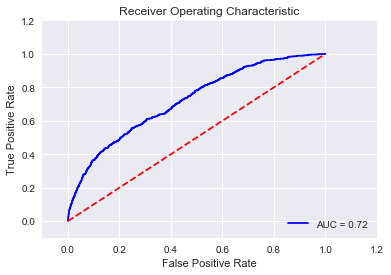

In [46]:
# Compute the FPR, TPR
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

# Plot an ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part G3 - Look at the initial confusion matrix

In [47]:
y_array = np.array(y_train)
confusion_output = metrics.confusion_matrix(y_array, predicts)
#print (confusion_output)
true_positive = confusion_output[1][0] # student enrolled and we predicted they would enroll
false_positive = confusion_output[1][1] # student enrolled and we predicted they wouldn't enroll
true_negative = confusion_output[0][0] # student didn't enroll and we predicted they wouldn't enroll
false_negative = confusion_output[0][1] # student didn't enroll and we predicted they would enroll 
precision = true_positive * 1.0 / (true_positive + false_positive)
recall = true_positive * 1.0 / (true_positive + false_negative)
f_score = (precision * recall * 2.0) / (precision + recall)

print ('Of the',true_positive+false_positive,'students who enrolled at the UW, we correctly predicted',true_positive,'of them')
print ('Of the',true_positive+false_negative,'students who we predicted would enroll at the UW',true_positive,'of them did')
if detailed_accuracy_metrics:
    print ('True positive',true_positive,', False Positive',false_positive)
    print ('True negative',true_negative,', False Negative',false_negative)
    print ('Precision:',precision,'Recall:', recall, 'F-Score:',f_score)

('Of the', 1509, 'students who enrolled at the UW, we correctly predicted', 789, 'of them')
('Of the', 796, 'students who we predicted would enroll at the UW', 789, 'of them did')
('True positive', 789, ', False Positive', 720)
('True negative', 11615, ', False Negative', 7)
('Precision:', 0.52286282306163023, 'Recall:', 0.99120603015075381, 'F-Score:', 0.68459869848156185)


In [48]:
# Now do it for the TEST set
y_array = np.array(y_test)
confusion_output = metrics.confusion_matrix(y_array, predicts_test)
#print (confusion_output)
true_positive = confusion_output[1][0] # student enrolled and we predicted they would enroll
false_positive = confusion_output[1][1] # student enrolled and we predicted they wouldn't enroll
true_negative = confusion_output[0][0] # student didn't enroll and we predicted they wouldn't enroll
false_negative = confusion_output[0][1] # student didn't enroll and we predicted they would enroll 
precision = true_positive * 1.0 / (true_positive + false_positive)
recall = true_positive * 1.0 / (true_positive + false_negative)
f_score = (precision * recall * 2.0) / (precision + recall)

print ('Of the',true_positive+false_positive,'students who enrolled at the UW, we correctly predicted',true_positive,'of them')
print ('Of the',true_positive+false_negative,'students who we predicted would enroll at the UW',true_positive,'of them did')
if detailed_accuracy_metrics:
    print ('True positive',true_positive,', False Positive',false_positive)
    print ('True negative',true_negative,', False Negative',false_negative)
    print ('Precision:',precision,'Recall:', recall, 'F-Score:',f_score)

('Of the', 689, 'students who enrolled at the UW, we correctly predicted', 595, 'of them')
('Of the', 697, 'students who we predicted would enroll at the UW', 595, 'of them did')
('True positive', 595, ', False Positive', 94)
('True negative', 4837, ', False Negative', 102)
('Precision:', 0.86357039187227869, 'Recall:', 0.85365853658536583, 'F-Score:', 0.85858585858585856)


### Part G4 - Find the best thresholds, F-Score optimize

In [73]:
def change_cutpoint(new_threshold, probs):
    array_to_return = np.zeros(len(probs))
    for index, value in enumerate(probs):
        if value >= new_threshold:
            #print index
            array_to_return[index] = 1
    return array_to_return

In [74]:
array_to_return = np.zeros(60)
array_to_return[50] = 1
array_to_return

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [75]:
change_cutpoint(0.45, probs_test[:, 1])

array([ 1.,  0.,  1., ...,  0.,  0.,  0.])

In [ ]:
y_array = np.array(y_test)

for number in range(100):
    cutoff = number / 100.0
    new_predictions = change_cutpoint(cutoff, probs_test[:, 1])
    confusion_output = metrics.confusion_matrix(y_array, new_predictions)
    #print (confusion_output)
    true_positive = confusion_output[1][0] # student enrolled and we predicted they would enroll
    false_positive = confusion_output[1][1] # student enrolled and we predicted they wouldn't enroll
    true_negative = confusion_output[0][0] # student didn't enroll and we predicted they wouldn't enroll
    false_negative = confusion_output[0][1] # student didn't enroll and we predicted they would enroll 
    precision = true_positive * 1.0 / (true_positive + false_positive)
    recall = true_positive * 1.0 / (true_positive + false_negative)
    f_score = (precision * recall * 2.0) / (precision + recall)
    print ('Cutoff',cutoff,'Precision',precision,'Recall', recall, 'F-Score',f_score,'TruePositive'
           ,true_positive, 'FalsePositive',false_positive,'TrueNegative',true_negative,'FalseNegative',false_negative)

#print ('Of the',true_positive+false_positive,'students who enrolled at the UW, we correctly predicted',true_positive,'of them')
#print ('Of the',true_positive+false_negative,'students who we predicted would enroll at the UW',true_positive,'of them did')
#if detailed_accuracy_metrics:
#    print ('True positive',true_positive,', False Positive',false_positive)
#    print ('True negative',true_negative,', False Negative',false_negative)   

#### Results Tracking

* Store in a Google sheet, https://docs.google.com/a/uw.edu/spreadsheets/d/1ne3dhmafyKZQNlTm7dlONYXvflGP-r3K-CeHfnOO6Qw/edit?usp=sharing 


### Part G4 - Save Everything Off

* Use pickle, https://docs.python.org/2/library/pickle.html 

In [46]:
if save_results:
    output_name = 'boosting_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL)

In [86]:
if save_results:
    df_5.to_csv('Transformed_Data_set_v3.csv', index=False)
    print ('Saved off transformed data set')
    df_5.describe()

Saved off transformed data set


## Part H - Propensity Score Matching

### Resources

**Highly Useful Code and Guides**

* https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching
* https://www.quora.com/Where-can-I-find-a-good-writeup-about-propensity-models


**Code**
* http://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb
* https://github.com/laurencium/causalinference
* https://github.com/MacHu-GWU/ctmatching-project

**Documentation/Guides**
* http://laurence-wong.com/software/


### Steps



1. Predict the probabilities (use the *entire* set)
2. Add in tuition info
3. Run through causal inference, using tuition as the effect to estimate
4. Split into buckets based on tuition_remaining. Or use stratified, which is better
    * Visualize the causal factor of each bucket


#### Part H1 - Predict the Probabilities

In [48]:
# Predict the probabilities
predictions = clf.predict_proba(x)

#sns.jointplot(x="tuition_after_grants", y="IsEnrolledOrMatriculated", data=df);

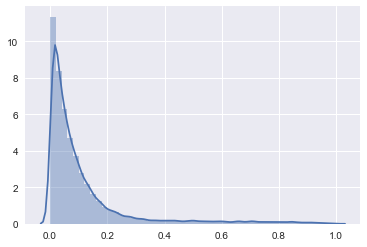

In [49]:
# Visualize the probabilities
sns.distplot(predictions[:, 1], hist=True, rug=False);

#### Part H2 - Add in tuition info

In [50]:
if use_all_years == False:
    df_tuition = df_backup.loc[df_backup['yr'] == year]
    df_tuition.reset_index(inplace=True)
else:
    df_tuition = df_backup.copy(deep=True)

In [51]:
df_tuition.loc[df_tuition.yr == 2010, 'Tuition'] = 25329
df_tuition.loc[df_tuition.yr == 2011, 'Tuition'] = 28058
df_tuition.loc[df_tuition.yr == 2012, 'Tuition'] = 29938
df_tuition.loc[df_tuition.yr == 2013, 'Tuition'] = 31971
df_tuition.loc[df_tuition.yr == 2014, 'Tuition'] = 33513
df_tuition.loc[df_tuition.yr == 2015, 'Tuition'] = 34143
df_tuition.loc[df_tuition.yr == 2016, 'Tuition'] = 34791

/Users/devnambi/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
df_tuition['tuition_after_grants'] = df_tuition['Tuition'] - df_tuition['PurpleAndGoldAmount'] - df_tuition['Grants_and_Scholarships']
df_tuition.loc[df_tuition.tuition_after_grants < 0, 'tuition_after_grants'] = 0

/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [53]:
df_tuition.tuition_after_grants.describe()

count    18759.000000
mean     32060.972813
std       3328.246833
min      19476.000000
25%      28291.000000
50%      34791.000000
75%      34791.000000
max      34791.000000
Name: tuition_after_grants, dtype: float64

In [54]:
#df_tuition.columns

In [55]:
df_tuition.drop('TotalBudget', axis=1, inplace=True)
df_tuition.drop('TotalBudgetRemaining', axis=1, inplace=True)
df_tuition.drop('Tuition', axis=1, inplace=True)
df_tuition.drop('TuitionRemaining', axis=1, inplace=True)
df_tuition.drop('WorkLoans', axis=1, inplace=True)
df_tuition.drop('UW_Grants', axis=1, inplace=True)
df_tuition.drop('Grants_and_Scholarships', axis=1, inplace=True)
df_tuition.drop('AcademicRank', axis=1, inplace=True)
df_tuition.drop('PurpleAndGoldAmount', axis=1, inplace=True)

/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/devnambi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/devnambi/anaconda/l

In [56]:
predict_df = df_3[['Fisap_Income', 'EFC', 'AcademicScore','DeltaAcademicMinusIncome', 'LowerIncomePct', 'DeltaParentEdMinusAcademic','IsEnrolledOrMatriculated']].copy(deep=True)
predict_df['PredictionScore'] = predictions[:, 1]
predict_df['TuitionRemaining'] = df_tuition.tuition_after_grants
predict_df['TuitionRemaining'] = np.round(predict_df['TuitionRemaining'] / 100)

In [57]:
# Split into buckets
bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.4,0.6, 0.8, 1.0]
bin_name = [0,1,2,3,4,5,6,7,8,9]

In [58]:
predict_df['PredictionBin'] = pd.cut(predict_df['PredictionScore'], bins, labels=bin_name)

In [59]:
df_tuition.tuition_after_grants.head()

0    34791
1    34791
2    34791
3    34791
4    34791
Name: tuition_after_grants, dtype: int64

#### Use the CausalInference library
* https://github.com/laurencium/causalinference/blob/master/docs/tex/vignette.pdf

In [60]:
#causal = CausalModel(Y, D, X)
# Y 'an N-vector of observed outcomes'
# D 'an N-vector of treatment status indicators'
# X 'an N-by-K matrix of covariates'

In [61]:
d_causal = predict_df.IsEnrolledOrMatriculated
y_causal = predict_df.PredictionScore

x_causal = predict_df.copy()
x_causal.drop('PredictionScore', axis=1, inplace=True)
#x_causal.drop('TuitionRemaining', axis=1, inplace=True)
x_causal.drop('PredictionBin', axis=1, inplace=True)
x_causal.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

print (x_causal.columns)

Index([u'Fisap_Income', u'EFC', u'AcademicScore', u'DeltaAcademicMinusIncome',
       u'LowerIncomePct', u'DeltaParentEdMinusAcademic', u'TuitionRemaining'],
      dtype='object')


In [62]:
x_causal2 = x_causal.apply(pd.to_numeric, errors='ignore')

In [63]:
[x_causal2.iloc[:,i].apply(type).value_counts() for i in range(x_causal2.shape[1])]

[<type 'long'>    18759
 Name: Fisap_Income, dtype: int64, <type 'long'>    18759
 Name: EFC, dtype: int64, <type 'float'>    18759
 Name: AcademicScore, dtype: int64, <type 'float'>    18759
 Name: DeltaAcademicMinusIncome, dtype: int64, <type 'float'>    18759
 Name: LowerIncomePct, dtype: int64, <type 'float'>    18759
 Name: DeltaParentEdMinusAcademic, dtype: int64, <type 'float'>    18759
 Name: TuitionRemaining, dtype: int64]

In [64]:
causal = CausalModel(y_causal, d_causal, x_causal2.as_matrix())

In [65]:
# Summary stats
print(causal.summary_stats)


Summary Statistics

                     Controls (N_c=16561)        Treated (N_t=2198)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.075        0.087        0.402        0.271        0.327

                     Controls (N_c=16561)        Treated (N_t=2198)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0   135992.290   182478.013   150785.820   193858.124        0.079
             X1    41113.820    76464.193    52512.698    94071.110        0.133
             X2        0.912        0.078        0.918        0.077        0.084
             X3        0.646        0.229        0.651        0.256        0.023
             X4        0.311        0.232        0.293        0.239       -0.075
      

In [66]:
# Propensity scoring
causal.est_propensity_s()
print (causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      6.540     15.965      0.410      0.682    -24.752     37.831
            X1      0.000      0.000      3.112      0.002      0.000      0.000
            X4     -3.116      2.350     -1.326      0.185     -7.722      1.489
            X2    -30.919     11.555     -2.676      0.007    -53.568     -8.270
            X6      0.045      0.066      0.675      0.500     -0.085      0.175
            X0     -0.000      0.000     -4.775      0.000     -0.000     -0.000
            X5      0.576      0.398      1.448      0.148     -0.204      1.356
            X3     -1.762      0.734     -2.400      0.016     -3.201     -0.323
         X5*X5      4.144      0.321     12.898      0.000      3.514      4.774
         X4*X6      0.027      0.004      7.275      0.000      0.

In [67]:
causal.propensity.keys()

['coef', 'lin', 'qua', 'loglike', 'fitted', 'se']

In [68]:
#causal.est_via_matching()
causal.est_via_ols()
causal.est_via_weighting()
#causal.est_via_blocking()
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.309      0.009     35.537      0.000      0.292      0.326

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.325      0.006     57.781      0.000      0.314      0.336
           ATC      0.325      0.006     57.612      0.000      0.314      0.336
           ATT      0.323      0.006     57.900      0.000      0.312      0.334



In [69]:
causal.stratify_s()
print(causal.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.000     0.060      2272        74     0.041     0.045     0.427
         2     0.060     0.081      2220       125     0.071     0.072     0.316
         3     0.081     0.089      1086        87     0.085     0.086     0.298
         4     0.089     0.095      1061       111     0.092     0.092     0.223
         5     0.095     0.108      2099       245     0.102     0.102     0.256
         6     0.108     0.142      4013       677     0.124     0.124     0.265
         7     0.142     0.175      1968       377     0.156     0.156     0.296
         8     0.175     0.208       957       215     0.189     0.190     0.359
         9     0.208     0.248       474       112     0.224     0.225     0.410
   

In [70]:
for index, stratum in enumerate(causal.strata):
    print('Strata Number',index+1)
    stratum.est_propensity_s()
    print(stratum.propensity)

('Strata Number', 1)

Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      1.684      2.540      0.663      0.507     -3.295      6.663
            X0      0.000      0.000      3.679      0.000      0.000      0.000
            X2     -3.294      1.087     -3.031      0.002     -5.424     -1.164
            X6     -0.010      0.006     -1.661      0.097     -0.022      0.002
            X5     -0.889      0.703     -1.265      0.206     -2.267      0.488
         X0*X0     -0.000      0.000     -4.325      0.000     -0.000     -0.000
         X0*X6     -0.000      0.000     -2.877      0.004     -0.000     -0.000

('Strata Number', 2)

Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
-------------------------------------------------------------

/Users/devnambi/anaconda/lib/python2.7/site-packages/causalinference/core/propensity.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.linalg.inv(H)))


In [71]:
#dir(causal.strata[0])